<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/CNN/drone_vs_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasyfikator binarny - Dron czy samolot?

### Import bibliotek

In [1]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

TensorFlow 2.x selected.


### Załadowanie modelu

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2019-12-29 00:18:41--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   225MB/s    in 6.9s    

2019-12-29 00:18:48 (212 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [0]:
!rm -rf ./images

In [4]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'passenger-plane']
for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('passenger-plane', 1424)])

In [0]:
data_dir = './images'

if not os.path.exists(data_dir):
  os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir,
        valid_drone_dir, valid_passenger_dir,
        test_drone_dir, test_passenger_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)

In [0]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [0]:
size = min(len(drone_fnames), len(passenger_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = valid_idx + train_size + test_size

In [68]:
for i, fname in enumerate(drone_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(train_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i < valid_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(valid_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(test_drone_dir, fname)
    shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(train_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i < valid_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(valid_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(test_passenger_dir, fname)
    shutil.copyfile(src, dst)

print('dron - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('dron - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('dron - zbiór testowy', len(os.listdir(test_drone_dir)))

print('samolot - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('samolot - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('samolot - zbiór testowy', len(os.listdir(test_passenger_dir)))

dron - zbiór treningowy 919
dron - zbiór walidacyjny 261
dron - zbiór testowy 131
samolot - zbiór treningowy 919
samolot - zbiór walidacyjny 261
samolot - zbiór testowy 231


### Eksploracja danych

(-0.5, 959.5, 639.5, -0.5)

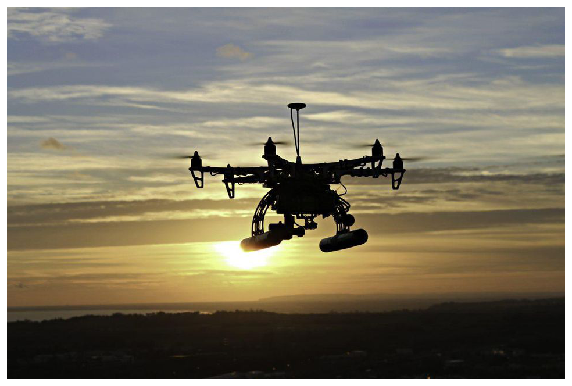

In [35]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 763 #@param {type: 'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### Augmentacja danych

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta, o który losowo zostanie wykonany obrót obrazków
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zakres losowego przycinania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest')    # strategia wypełniania nowo utworzonych pikseli, 
                            # które mogą powstać w wyniku przekształceń

# przeskalowujemy wszystkie obrazy o współczynniku 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [0]:
def display_augmented_images(directory, idx):
  """
  Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
  augmentacji danych.
  """
  fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
  img_path = fnames[idx]
  img = image.load_img(img_path, target_size=(150, 150))

  x = image.img_to_array(img)
  x = x.reshape((1, ) + x.shape)

  i = 1
  plt.figure(figsize=(20, 14))
  for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
      break

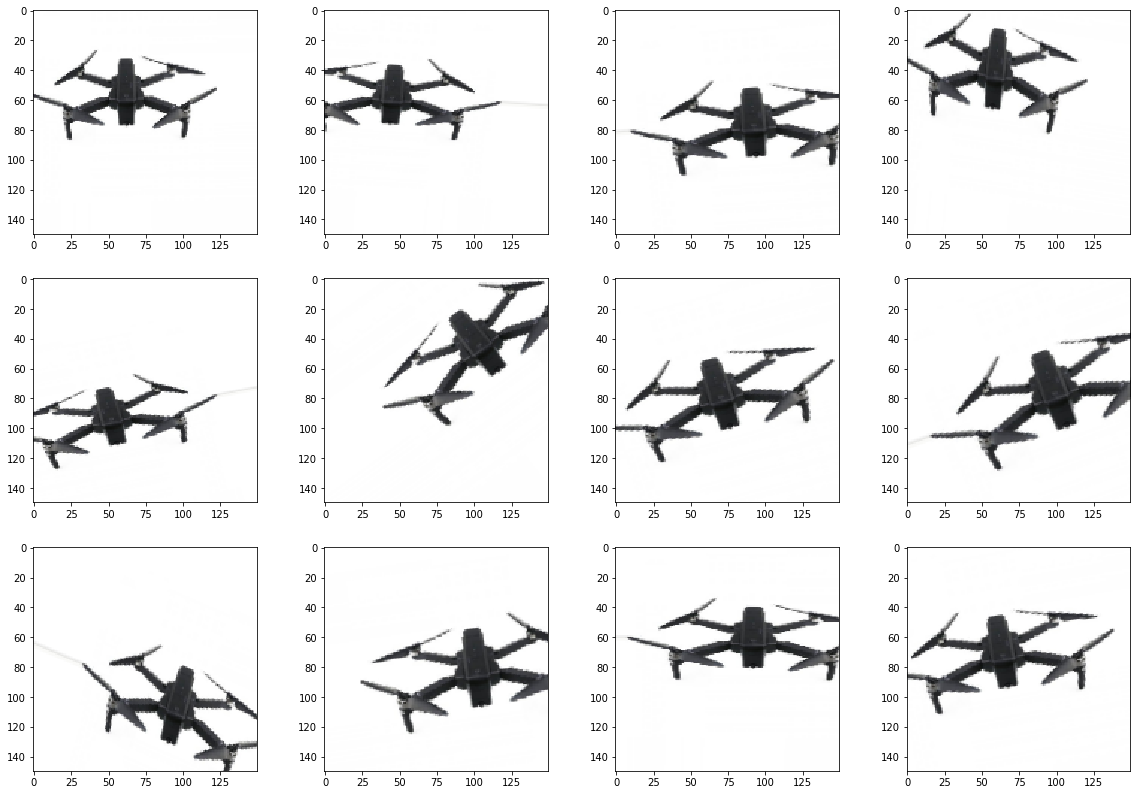

In [30]:
#@title Zbiór treningowy drone:
idx = 580 #@param {type: 'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

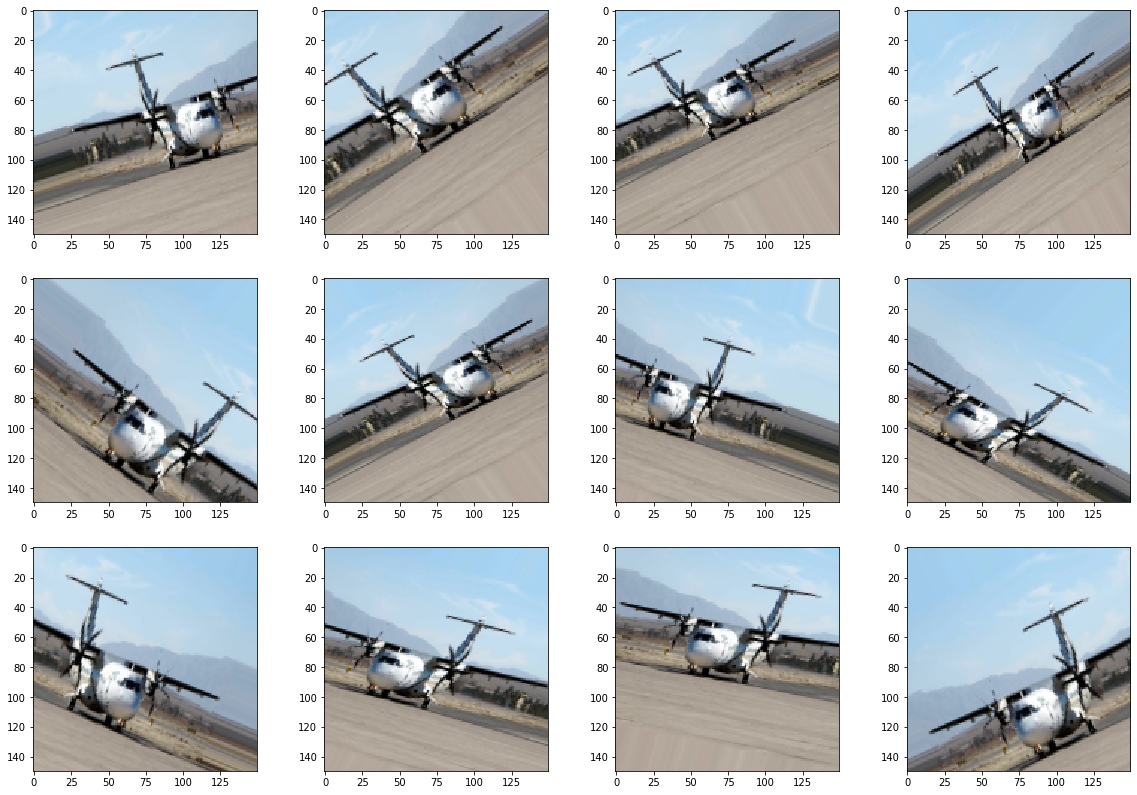

In [34]:
#@title Zbiór treningowy passenger:
idx = 500 #@param {type: 'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

### Budowa modelu

In [14]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
!rm -rf logs 
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [17]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=30,
                              validation_data=valid_generator,
                              validation_steps=validation_steps,
                              callbacks=[tensorboard])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 8 steps
Epoch 1/30
28/28 [==============================] - 28s 1s/step - loss: 0.6940 - accuracy: 0.5205 - val_loss: 0.6950 - val_accuracy: 0.4922
Epoch 2/30
28/28 [==============================] - 22s 787ms/step - loss: 0.6918 - accuracy: 0.5194 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 3/30
28/28 [==============================] - 23s 823ms/step - loss: 0.6830 - accuracy: 0.5444 - val_loss: 0.6769 - val_accuracy: 0.6094
Epoch 4/30
28/28 [==============================] - 23s 813ms/step - loss: 0.6773 - accuracy: 0.5638 - val_loss: 0.6927 - val_accuracy: 0.5312
Epoch 5/30
28/28 [==============================] - 23s 818ms/step - loss: 0.6716 - accuracy: 0.5854 - val_loss: 0.6707 - val_accuracy: 0.5820
Epoch 6/30
28/28 [==============================] - 24s 843ms/step - loss: 0.6676 - accuracy: 0.6094 - val_loss: 0.6712 -

In [0]:
%load_ext tensorboard

In [0]:
!tensorboard dev upload --logdir logs

In [22]:
def plot_hist(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
  fig.update_layout(width=1000, height=500, title='Accuracy vs Val Accuracy', 
                    xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
  fig.update_layout(width=1000, height=500, title='Loss vs Val Loss', 
                    xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
  fig.show()

plot_hist(history)

### Transfer Learning - model VGG16

In [41]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,  # czy dołączyc górną część sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [42]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [43]:
print(f'Liczba warstw trenowanych przed zamrożeniem: {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Liczba wartsw trenowanych po zamrożeniu: {len(model.trainable_weights)}')

Liczba warstw trenowanych przed zamrożeniem: 30
Liczba wartsw trenowanych po zamrożeniu: 4


In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=50,
                              validation_data=valid_generator,
                              validation_steps=validation_steps,
                              callbacks=[tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 8 steps
Epoch 1/50
28/28 [==============================] - 24s 870ms/step - loss: 0.6699 - accuracy: 0.6194 - val_loss: 0.5274 - val_accuracy: 0.7305
Epoch 2/50
28/28 [==============================] - 23s 804ms/step - loss: 0.5231 - accuracy: 0.7415 - val_loss: 0.5171 - val_accuracy: 0.7383
Epoch 3/50
28/28 [==============================] - 23s 823ms/step - loss: 0.5083 - accuracy: 0.7483 - val_loss: 0.5095 - val_accuracy: 0.7422
Epoch 4/50
28/28 [==============================] - 21s 756ms/step - loss: 0.4791 - accuracy: 0.7494 - val_loss: 0.5221 - val_accuracy: 0.7383
Epoch 5/50
28/28 [==============================] - 23s 830ms/step - loss: 0.4770 - accuracy: 0.7642 - val_loss: 0.4515 - val_accuracy: 0.7617
Epoch 6/50
28/28 [==============================] - 22s 769ms/step - loss: 0.4331 - accuracy: 0.7938 - val_loss: 0.4857 - val_accuracy: 0.7500
Epoch 7/50
28/28 [==============================] -

In [47]:
import plotly.graph_objects as go
plot_hist(history)

### Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw

In [51]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(models):
  for layer in model.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: vgg16         trainable: True
layer_name: flatten_4     trainable: True
layer_name: dense_8       trainable: True
layer_name: dense_9       trainable: True


In [49]:
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

print_layers(conv_base)

layer_name: vgg16         trainable: False
layer_name: flatten_3     trainable: True
layer_name: dense_6       trainable: True
layer_name: dense_7       trainable: True


In [50]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [52]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=30,
                              validation_data=valid_generator,
                              validation_steps=validation_steps,
                              callbacks=[tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 8 steps
Epoch 1/30
28/28 [==============================] - 23s 815ms/step - loss: 0.6580 - accuracy: 0.6777 - val_loss: 0.5251 - val_accuracy: 0.7305
Epoch 2/30
28/28 [==============================] - 23s 809ms/step - loss: 0.5260 - accuracy: 0.7267 - val_loss: 0.5568 - val_accuracy: 0.7383
Epoch 3/30
28/28 [==============================] - 23s 837ms/step - loss: 0.4911 - accuracy: 0.7489 - val_loss: 0.5029 - val_accuracy: 0.7461
Epoch 4/30
28/28 [==============================] - 23s 817ms/step - loss: 0.4863 - accuracy: 0.7634 - val_loss: 0.4517 - val_accuracy: 0.7617
Epoch 5/30
28/28 [==============================] - 23s 817ms/step - loss: 0.4233 - accuracy: 0.7913 - val_loss: 0.5114 - val_accuracy: 0.7773
Epoch 6/30
28/28 [==============================] - 25s 880ms/step - loss: 0.4162 - accuracy: 0.8075 - val_loss: 0.7512 - val_accuracy: 0.6602
Epoch 7/30
28/28 [==============================] -

In [53]:
plot_hist(history)

### Ocena modelu na zbiorze testowym

In [69]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 362 images belonging to 2 classes.


array([0.874849, 0.      , 0.      , 0.000109, 0.48979 , 0.      ,
       0.      , 0.      , 0.761841, 0.      , 0.      , 0.00006 ,
       0.001774, 0.000014, 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.000198, 0.000994, 0.998195, 0.027404, 0.011649,
       0.000118, 0.003202, 0.036428, 0.      , 0.283405, 0.      ,
       0.      , 0.      , 0.00638 , 0.00652 , 0.003696, 0.052155,
       0.001404, 0.      , 0.      , 0.      , 0.210377, 0.      ,
       0.006748, 0.003102, 0.005451, 0.      , 0.295722, 0.611905,
       0.      , 0.      , 0.      , 0.030457, 0.00018 , 0.000704,
       0.      , 0.884717, 0.000022, 0.000135, 0.00039 , 0.      ,
       0.      , 0.      , 0.      , 0.115334, 0.000136, 0.071816,
       0.000175, 0.47301 , 0.000031, 0.      , 0.      , 0.000226,
       0.      , 0.016919, 0.180191, 0.0122  , 0.99835 , 0.01736 ,
       0.959905, 0.      , 0.001016, 0.000311, 0.257916, 0.022673,
       0.027241, 0.000818, 0.000001, 0.      , 0.024792, 0.000

In [70]:
predictions = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,8.748487e-01,1
1,5.289295e-20,0
2,6.632591e-09,0
3,1.088286e-04,0
4,4.897898e-01,0
...,...,...
357,2.799003e-01,0
358,8.359873e-01,1
359,8.447515e-01,1
360,1.000000e+00,1


In [71]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [72]:
y_pred = predictions['class'].values
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,

In [73]:
test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [74]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[118,  13],
       [ 40, 191]])

In [75]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       131
           1       0.94      0.83      0.88       231

    accuracy                           0.85       362
   macro avg       0.84      0.86      0.85       362
weighted avg       0.87      0.85      0.86       362



### Wyświetlenie błędów predykcji

In [78]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
drone/00000004.jpg,0,1
drone/00000006.jpg,0,0
drone/00000018.jpg,0,0
drone/00000040.jpg,0,0
drone/00000051.png,0,0


In [79]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000004.jpg,0,1,1
drone/00000006.jpg,0,0,0
drone/00000018.jpg,0,0,0
drone/00000040.jpg,0,0,0
drone/00000051.png,0,0,0
...,...,...,...
passenger/00001471.jpg,1,0,1
passenger/00001479.jpg,1,1,0
passenger/00001481.jpg,1,1,0
passenger/00001488.jpg,1,1,0


In [80]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000004.jpg', 'drone/00000077.jpg', 'drone/00000175.jpg',
       'drone/00000409.jpg', 'drone/00000473.png', 'drone/00000763.jpg',
       'drone/00000776.jpg', 'drone/00000938.png', 'drone/00001112.jpg',
       'drone/00001203.jpg', 'drone/00001248.png', 'drone/00001253.jpg',
       'drone/00001360.jpg', 'passenger/00000217.jpg',
       'passenger/00000227.jpg', 'passenger/00000241.jpg',
       'passenger/00000270.jpg', 'passenger/00000346.png',
       'passenger/00000362.jpg', 'passenger/00000394.jpg',
       'passenger/00000415.jpg', 'passenger/00000534.png',
       'passenger/00000556.jpg', 'passenger/00000557.jpg',
       'passenger/00000558.jpg', 'passenger/00000592.jpg',
       'passenger/00000610.jpg', 'passenger/00000615.jpg',
       'passenger/00000650.jpg', 'passenger/00000658.jpg',
       'passenger/00000659.jpg', 'passenger/00000669.jpg',
       'passenger/00000688.jpg', 'passenger/00000701.jpg',
       'passenger/00000736.jpg', 'passenger/00000763.jpg',
    

(-0.5, 839.5, 472.5, -0.5)

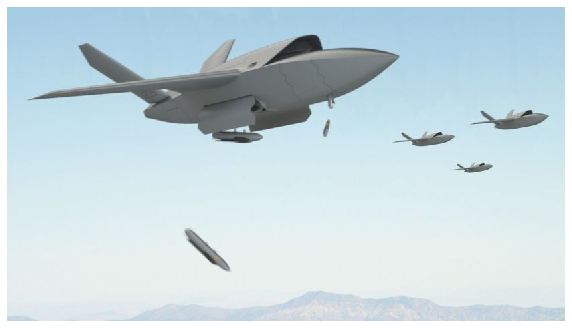

In [83]:
img_path = os.path.join(test_drone_dir, '00000776.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1279.5, 719.5, -0.5)

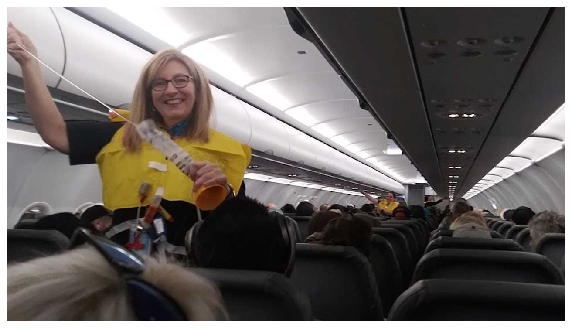

In [102]:
img_path = os.path.join(test_passenger_dir, '00001492.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)